In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [9]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [10]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [11]:
dir_SSS = su.get_dir_SSS()

In [12]:
dir_roi = su.get_dir_roi()

---

In [13]:
# border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

In [14]:
hem = 'L'

---

In [15]:
def plot_surf(data, cmap=cm.jet, title=None):
    if isinstance(data, str):
        data = nb.load(data).darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiImage):
        data = data.darrays[0].data
    elif isinstance(surf, nb.gifti.gifti.GiftiDataArray):
        data = data.data

    g = surf.plot.plotmap(
        data=data,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cmap,
        # colorbar=True,
        # cscale=[-1,7],
        # threshold=[-thresh,thresh],
        borders=border, bordercolor='white', bordersize=0.3,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=title, ha='center', va='center', fontsize=10)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

    return g

---
---

In [16]:
fname = join(dir_git,'fs_LR_32/BA_handArea.32k.%s.label.gii'%hem)
mask_tmp = nb.load(fname).darrays[0].data

In [17]:
idx_sm = (mask_tmp>0)
mask_sm = np.zeros_like(mask_tmp).astype(int)
mask_sm[idx_sm] = 1

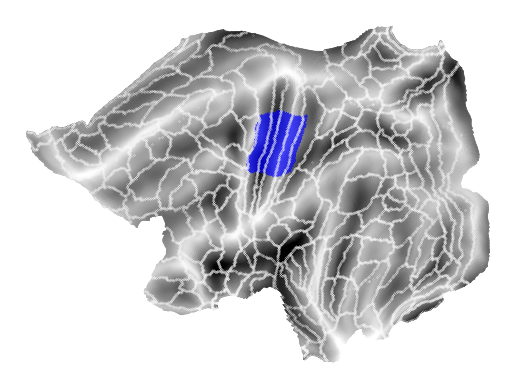

In [18]:
g = plot_surf(mask_sm , cmap=cm.jet.resampled(9))

---
---

In [16]:
glm = 1

In [17]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_group = join(dir_surf,'group')

In [18]:
thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=11)

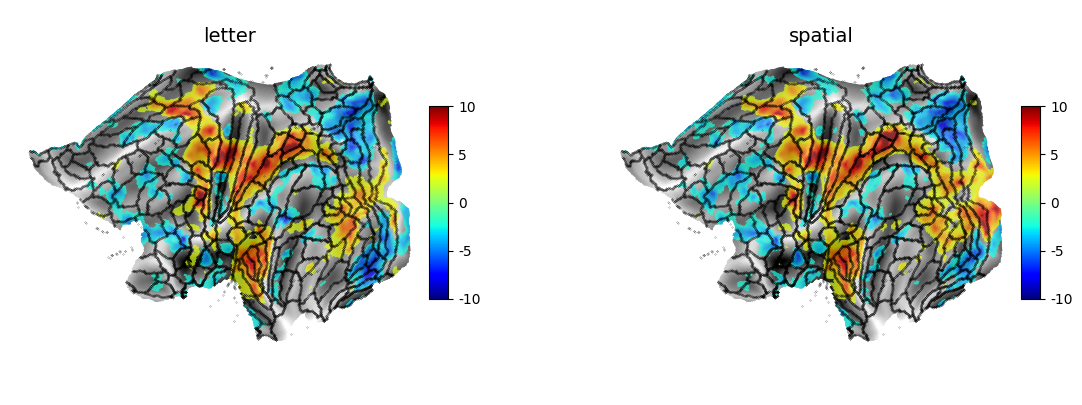

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(14,5))

for ii, sss in enumerate(['letter','spatial']):
    ax=axs[ii]
    plt.sca(ax)
    fname = join(dir_group,'cifti.%s.glm_%1d.t_stat.%s.dscalar.nii'%(hem,glm,sss))
    data = np.array(nb.load(fname).get_fdata())
    
    color = 'black'
    g = surf.plot.plotmap(
        data=data[1],
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cm.jet, colorbar=True,
        cscale=[-10,10],
        threshold=[-thresh,thresh],
        borders=border, bordercolor=color, bordersize=0.3,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=20, y=220, s=sss, ha='center', va='center', fontsize=14)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

---
---

In [19]:
df = pd.read_csv(join(dir_SSS,'atlas/Glasser_2016.32k.L.label.txt'), index_col=None, header=0, delimiter='\t')
df = df.iloc[:,1:-1]
df

,KEY,NAME,RED,GREEN,BLUE,ALPHA
0,0,???,1.000,1.000,1.000,0.0
1,1,L_V1_ROI,0.247,0.020,1.000,1.0
2,2,L_MST_ROI,0.212,0.404,0.506,1.0
3,3,L_V6_ROI,0.243,0.306,0.698,1.0
4,4,L_V2_ROI,0.090,0.196,0.914,1.0
...,...,...,...,...,...,...
176,176,L_STSva_ROI,0.157,0.129,0.086,1.0
177,177,L_TE1m_ROI,0.231,0.176,0.169,1.0
178,178,L_PI_ROI,0.478,0.196,0.196,1.0
179,179,L_a32pr_ROI,0.510,0.247,0.341,1.0


In [20]:
fname = join(dir_git,'fs_LR_32/Glasser_2016.32k.%s.label.gii'%hem)
gii = nb.load(fname)

In [21]:
mask_orig = gii.darrays[0].data
mask_orig.shape

(32492,)

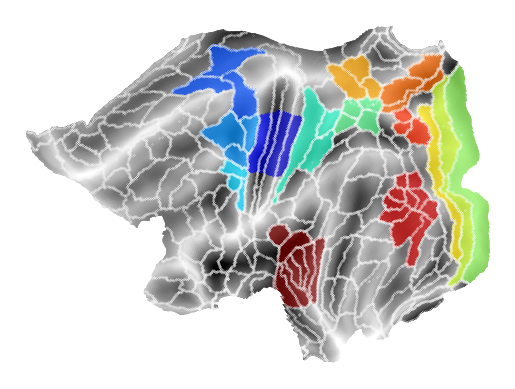

In [22]:
mask_new = np.zeros_like(mask_orig).astype(int)

N = 0
labels = {}
labels['S1'] = ['L_3b_ROI','L_3a_ROI','L_1_ROI']
labels['M1'] = ['L_4_ROI']
labels['SMA'] = ['L_SCEF_ROI','L_24dd_ROI','L_6mp_ROI']
labels['PMd'] = ['L_6a_ROI','L_6d_ROI','L_FEF_ROI']
labels['PMv'] = ['L_6v_ROI','L_PEF_ROI','L_55b_ROI']
labels['SPLa'] = ['L_2_ROI','L_AIP_ROI','L_7PC_ROI']
labels['SPLp'] = ['L_MIP_ROI','L_VIP_ROI','L_LIPv_ROI','L_7PL_ROI']
labels['V1'] = ['L_V1_ROI']
labels['V2'] = ['L_V2_ROI']
labels['V3'] = ['L_V3_ROI']
labels['A'] = ['L_7Pm_ROI','L_7Am_ROI','L_PCV_ROI']
labels['B'] = ['L_POS1_ROI','L_POS2_ROI','L_DVT_ROI']
labels['C'] = ['L_V6A_ROI','L_V7_ROI','L_V3A_ROI']
labels['D'] = ['L_LO1_ROI','L_LO2_ROI','L_LO3_ROI','L_MT_ROI','L_V4t_ROI','L_MST_ROI','L_FST_ROI','L_PH_ROI','L_FFC_ROI','L_PIT_ROI']
labels['E'] = ['L_OP1_ROI','L_RI_ROI','L_A1_ROI','L_A4_ROI','L_52_ROI','L_MBelt_ROI','L_LBelt_ROI','L_PBelt_ROI']
for ii, (roi, names) in enumerate(labels.items()):
    for jj, name in enumerate(names):
        val = int(df.loc[df.NAME.str.contains(name,na=False),'KEY'].iloc[0])
        idx = mask_orig == val
        if (roi=='S1')|(roi=='M1'):
            idx *= idx_sm
        mask_new[idx] = ii+1
    N += 1

g = plot_surf(mask_new , cmap=cm.jet.resampled(N+1))

In [28]:
simage.save_surf2cifti(
    data=mask_new[np.newaxis,:],
    label_axis=['value'],
    dir_output=dir_roi,
    prefix='SPark.32k.L.dlabel.nii',
    type_='dlabel'
)

---